In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
#import scrublet as scr # requires 'pip install scrublet'
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle
np.random.seed(0)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.0.1
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.4
cairo                       1.21.0
cffi                        1.15.0
cloudpickle                 2.0.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.02.1
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.17.3
fsspec                      2022.02.0
google                      NA
h5py                        3.6.0
igraph                      0.9.11
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywid

In [4]:
%%time
import os
holder = []
path = './00.data/'
files = os.listdir(path)
print(files)
for file in files:
    file_dir = os.path.join(path,file)
    print("开始处理：",file)
    holder.append(sc.read_10x_mtx(file_dir,var_names= 'gene_symbols',cache=True))
    holder[-1].var_names_make_unique()
     ##add metadata
    holder[-1].obs['ID'] = file.split('_')[1]
    holder[-1].obs['Type'] = file.split('_')[0]

['Control_220615', 'Control_220623', 'Control_220628', 'Drug_220708', 'Drug_220713', 'Taxol_220808', 'Taxol_220813', 'Vehicle_220804', 'Vehicle_220811']
开始处理： Control_220615
... reading from cache file cache\00.data-Control_220615-matrix.h5ad
开始处理： Control_220623
... reading from cache file cache\00.data-Control_220623-matrix.h5ad
开始处理： Control_220628
... reading from cache file cache\00.data-Control_220628-matrix.h5ad
开始处理： Drug_220708
... reading from cache file cache\00.data-Drug_220708-matrix.h5ad
开始处理： Drug_220713
... reading from cache file cache\00.data-Drug_220713-matrix.h5ad
开始处理： Taxol_220808
... reading from cache file cache\00.data-Taxol_220808-matrix.h5ad
开始处理： Taxol_220813
... reading from cache file cache\00.data-Taxol_220813-matrix.h5ad
开始处理： Vehicle_220804
... reading from cache file cache\00.data-Vehicle_220804-matrix.h5ad
开始处理： Vehicle_220811
... reading from cache file cache\00.data-Vehicle_220811-matrix.h5ad
CPU times: total: 3.95 s
Wall time: 5.55 s


In [26]:
%%time
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
adata.X = adata.X.tocsr()
adata.var_names_make_unique()

D:\conda\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
D:\conda\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


CPU times: total: 516 ms
Wall time: 502 ms


D:\conda\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [27]:
adata.obs

,ID,Type,batch
AAACCCAAGACCGCCT-1,220615,Control,0
AAACCCAAGCAAGTCG-1,220615,Control,0
AAACCCAAGGGAGGTG-1,220615,Control,0
AAACCCAAGGTCACTT-1,220615,Control,0
AAACCCAAGTCGCCCA-1,220615,Control,0
...,...,...,...
TTTGTTGGTGCCTGCA-1,220811,Vehicle,8
TTTGTTGGTGGTCTGC-1,220811,Vehicle,8
TTTGTTGTCAACACGT-1,220811,Vehicle,8
TTTGTTGTCATTGAGC-1,220811,Vehicle,8


In [28]:
adata.var

,gene_ids,feature_types
Xkr4,ENSMUSG00000051951,Gene Expression
Gm1992,ENSMUSG00000089699,Gene Expression
Gm19938,ENSMUSG00000102331,Gene Expression
Gm37381,ENSMUSG00000102343,Gene Expression
Rp1,ENSMUSG00000025900,Gene Expression
...,...,...
AC124606.1,ENSMUSG00000095523,Gene Expression
AC133095.2,ENSMUSG00000095475,Gene Expression
AC133095.1,ENSMUSG00000094855,Gene Expression
AC234645.1,ENSMUSG00000095019,Gene Expression


In [29]:
# Filer cells with less than 200 genes expressed
sc.pp.filter_cells(adata, min_genes=200)
# Filer genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

filtered out 3177 cells that have less than 200 genes expressed


D:\conda\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


filtered out 6810 genes that are detected in less than 3 cells


D:\conda\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [30]:
adata

AnnData object with n_obs × n_vars = 94573 × 25475
    obs: 'ID', 'Type', 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [31]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('mt-')
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^Hb[^(p)]"))

In [32]:
adata.var

,gene_ids,feature_types,n_cells,mt,ribo,hb
Xkr4,ENSMUSG00000051951,Gene Expression,4371,False,False,False
Gm1992,ENSMUSG00000089699,Gene Expression,144,False,False,False
Gm19938,ENSMUSG00000102331,Gene Expression,483,False,False,False
Gm37381,ENSMUSG00000102343,Gene Expression,4,False,False,False
Rp1,ENSMUSG00000025900,Gene Expression,56,False,False,False
...,...,...,...,...,...,...
Tmlhe,ENSMUSG00000079834,Gene Expression,2434,False,False,False
CR974586.4,ENSMUSG00000096506,Gene Expression,3,False,False,False
4933409K07Rik,ENSMUSG00000095552,Gene Expression,10,False,False,False
CAAA01147332.1,ENSMUSG00000095742,Gene Expression,683,False,False,False


In [33]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=False, inplace=True)

In [34]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

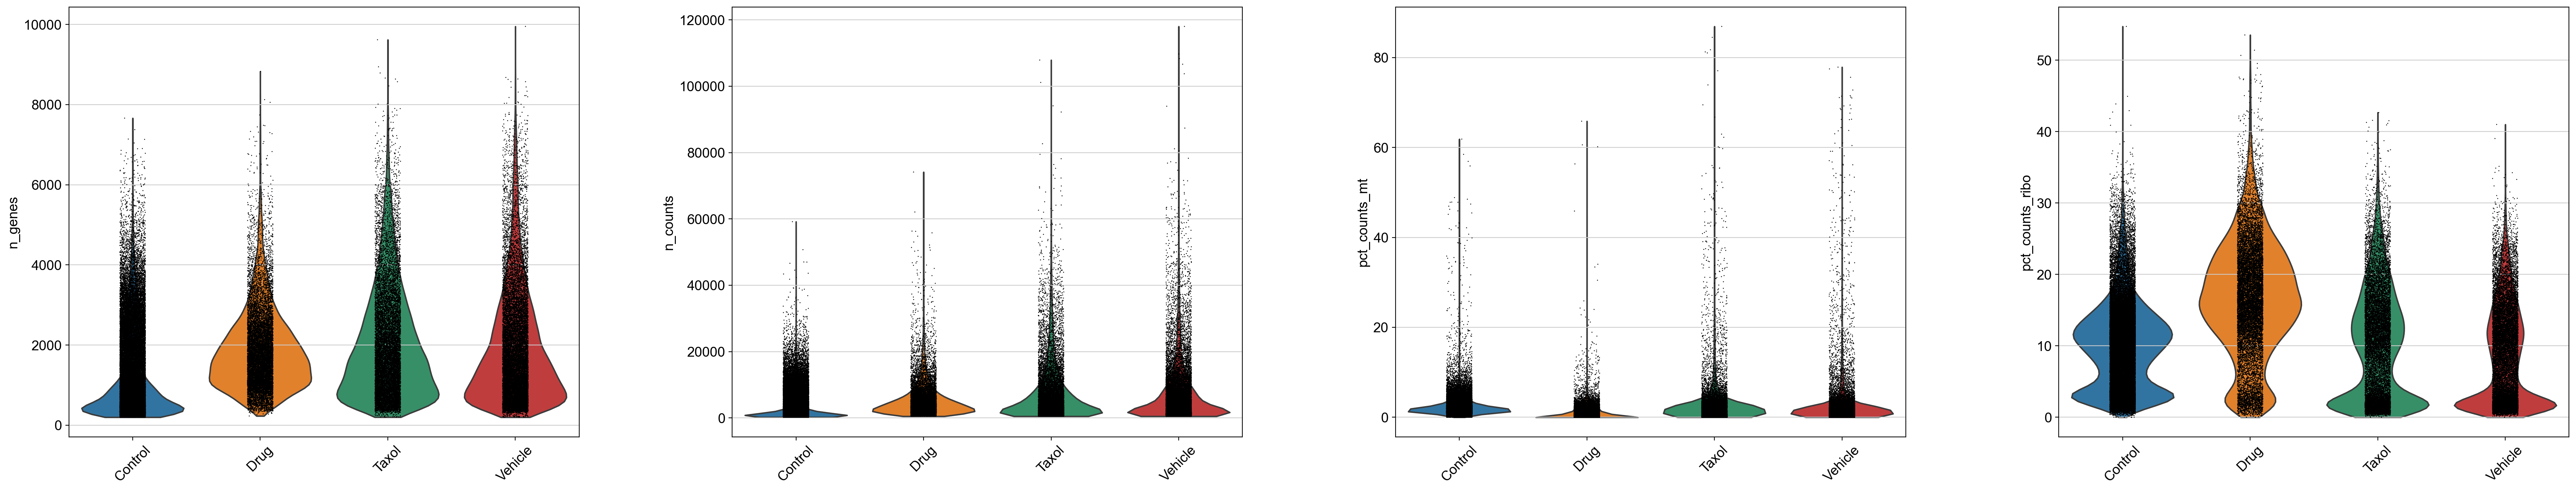

In [35]:
sc.settings.figdir = './result/'
plt.rcParams['figure.figsize']=(8,8)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'pct_counts_mt','pct_counts_ribo',],
             jitter=1, groupby = 'Type', rotation= 45,save='QC_befor.pdf')

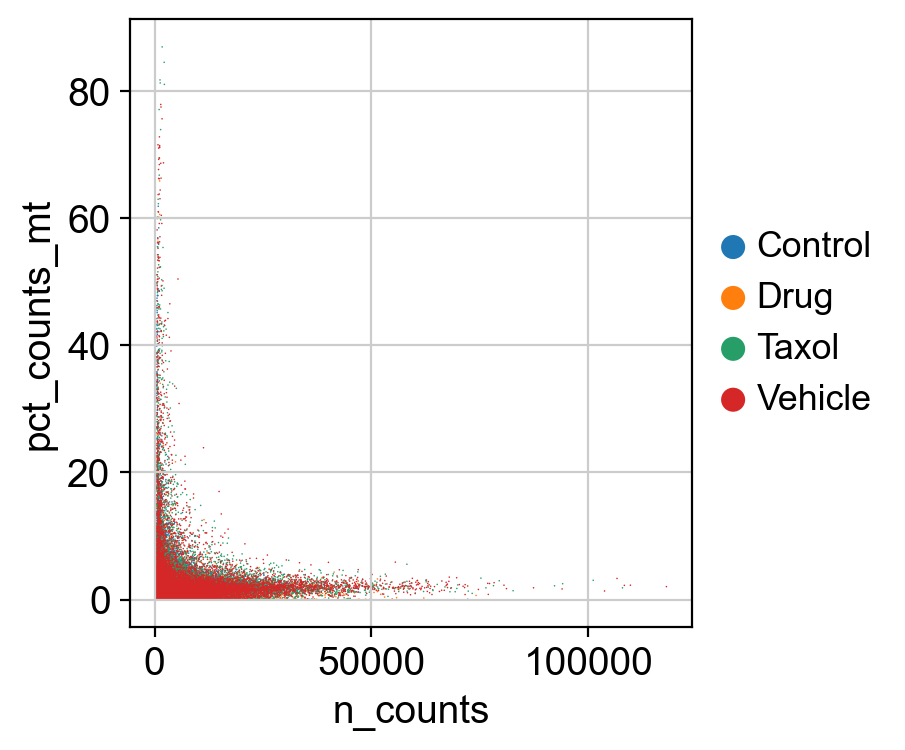

In [36]:
plt.rcParams['figure.figsize']=(4,4)
sc.pl.scatter(adata, x='n_counts', y='pct_counts_mt', color='Type',title='',save='QC_MT.pdf')

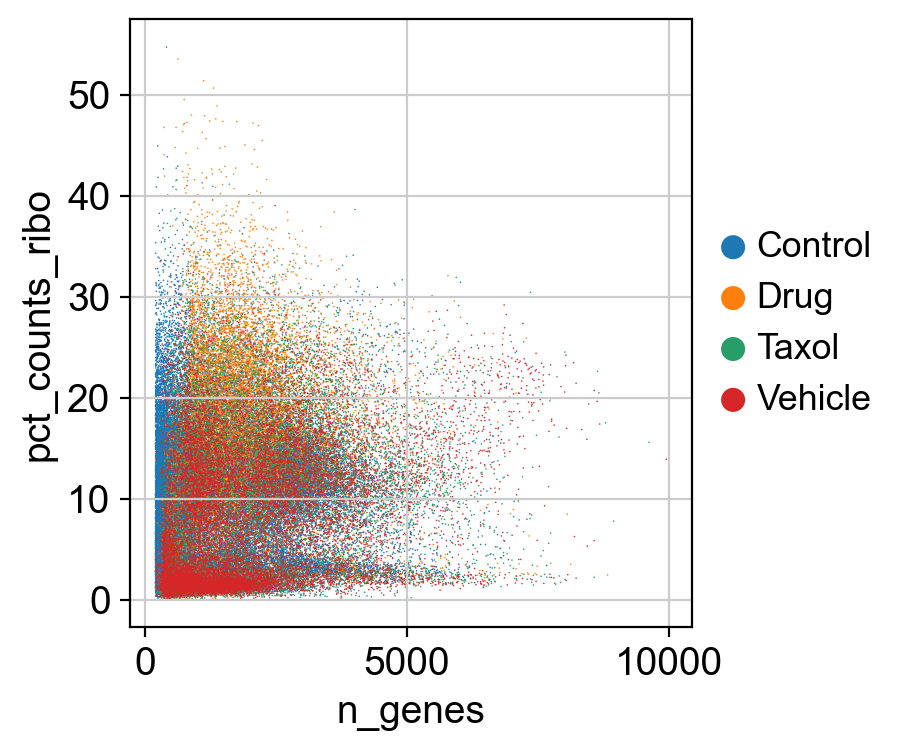

In [37]:
sc.pl.scatter(adata, x='n_genes', y='pct_counts_ribo', color='Type',title='',save='QC_rb.pdf')

In [38]:
print('Remaining cells %d'%adata.n_obs)

Remaining cells 94573


In [39]:
upper_lim = np.quantile(adata.obs.n_genes.values,.98)
lower_lim = np.quantile(adata.obs.n_genes.values,.02)
maxUMI = np.quantile(adata.obs.n_counts.values,.98)
print(f'{lower_lim} to {upper_lim}')
print(f'{maxUMI}')

242.0 to 5012.0
25750.0


In [40]:
ribo_lim =np.quantile(adata.obs.pct_counts_ribo.values,.02)
ribo_lim =5 if ribo_lim >5 else ribo_lim 
print(ribo_lim)

0.9052990007400513


In [41]:
adata = adata[(adata.obs.n_genes < upper_lim)& (adata.obs.n_genes > lower_lim)]
adata = adata[adata.obs.pct_counts_mt< 20,:]
adata = adata[adata.obs.n_counts <maxUMI]
adata = adata[adata.obs.pct_counts_ribo > ribo_lim]
print('Remaining cells %d'%adata.n_obs)

Remaining cells 88086


D:\conda\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell


D:\conda\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


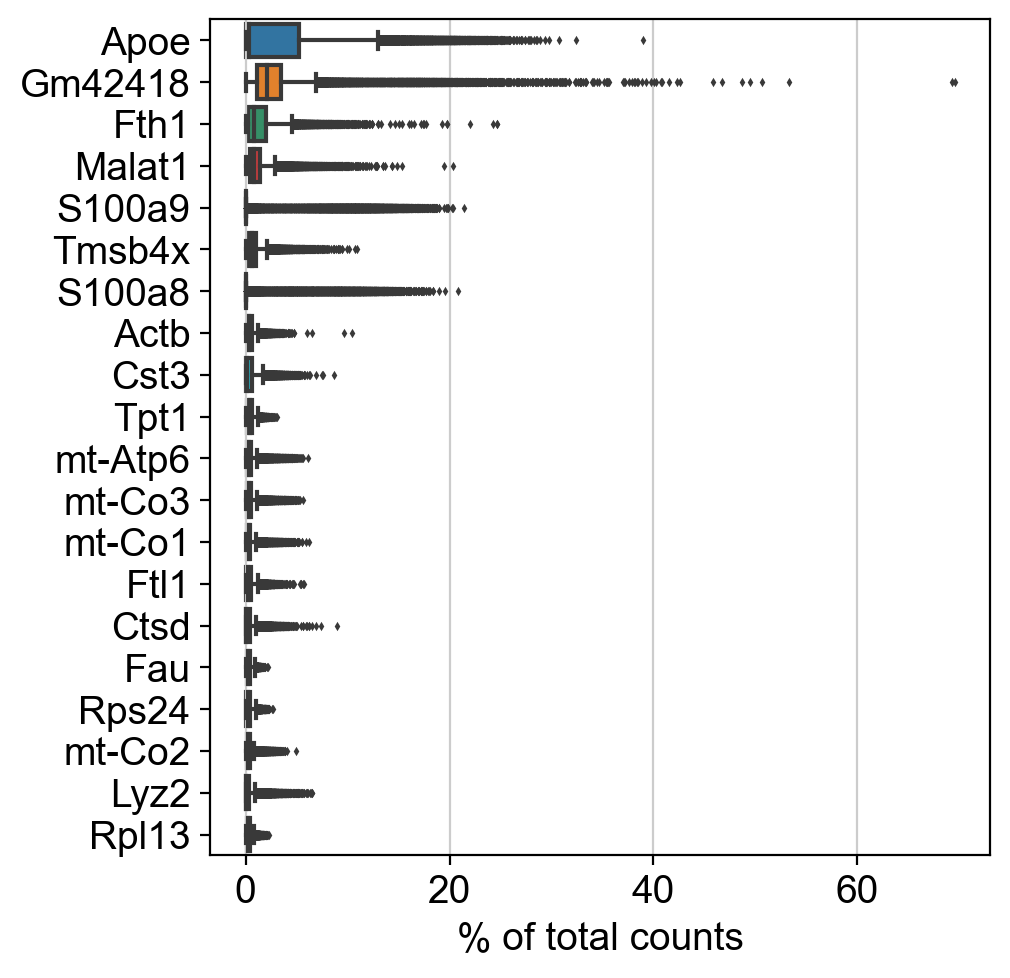

In [42]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [43]:
malat1 = adata.var_names.str.startswith('Malat1')
Rps_genes = adata.var_names.str.startswith("Rps")
Rpl_genes = adata.var_names.str.startswith("Rpl")

In [44]:
remove = np.add(Rps_genes, malat1)
remove = np.add(remove,Rpl_genes)
keep = np.invert(remove)
adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

88086 25375


D:\conda\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell


D:\conda\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


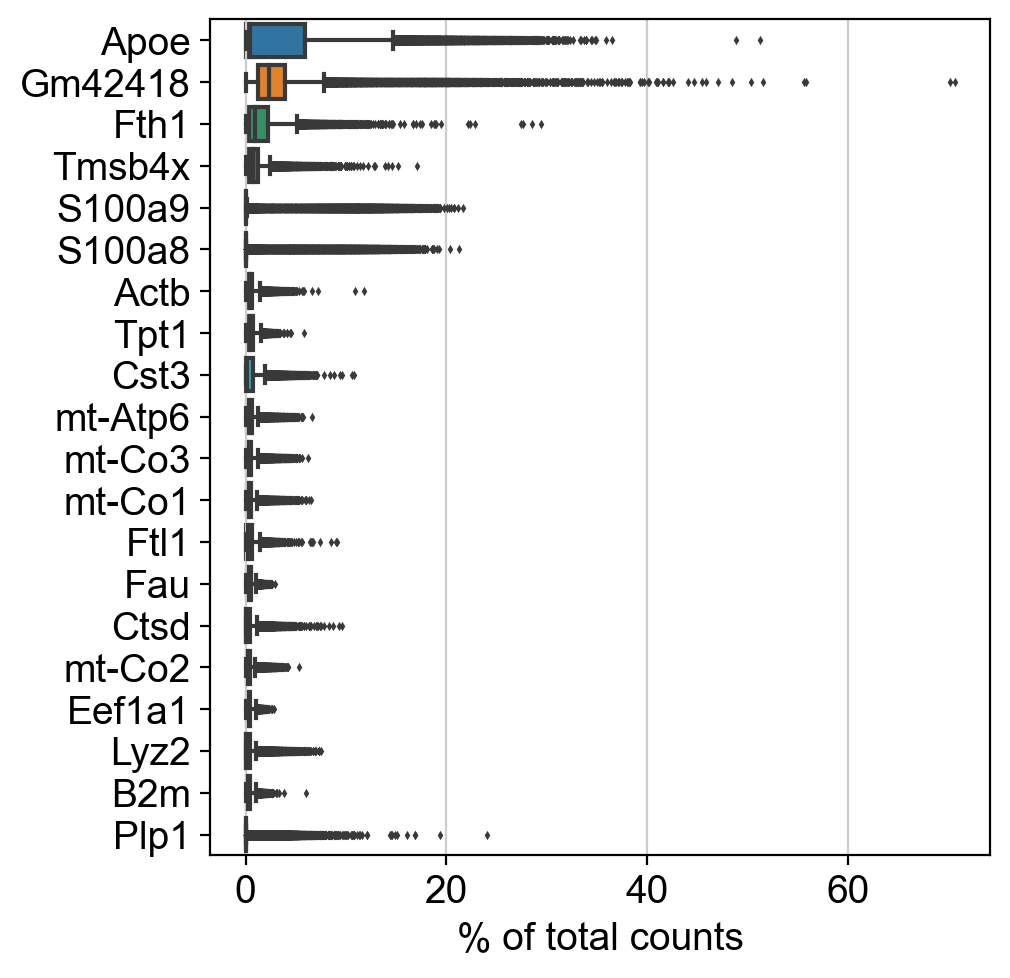

In [45]:
sc.pl.highest_expr_genes(adata, n_top=20,save='QC_top20.pdf')

In [46]:
import scrublet as scr

In [47]:
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.82
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.6%
Elapsed time: 177.6 seconds


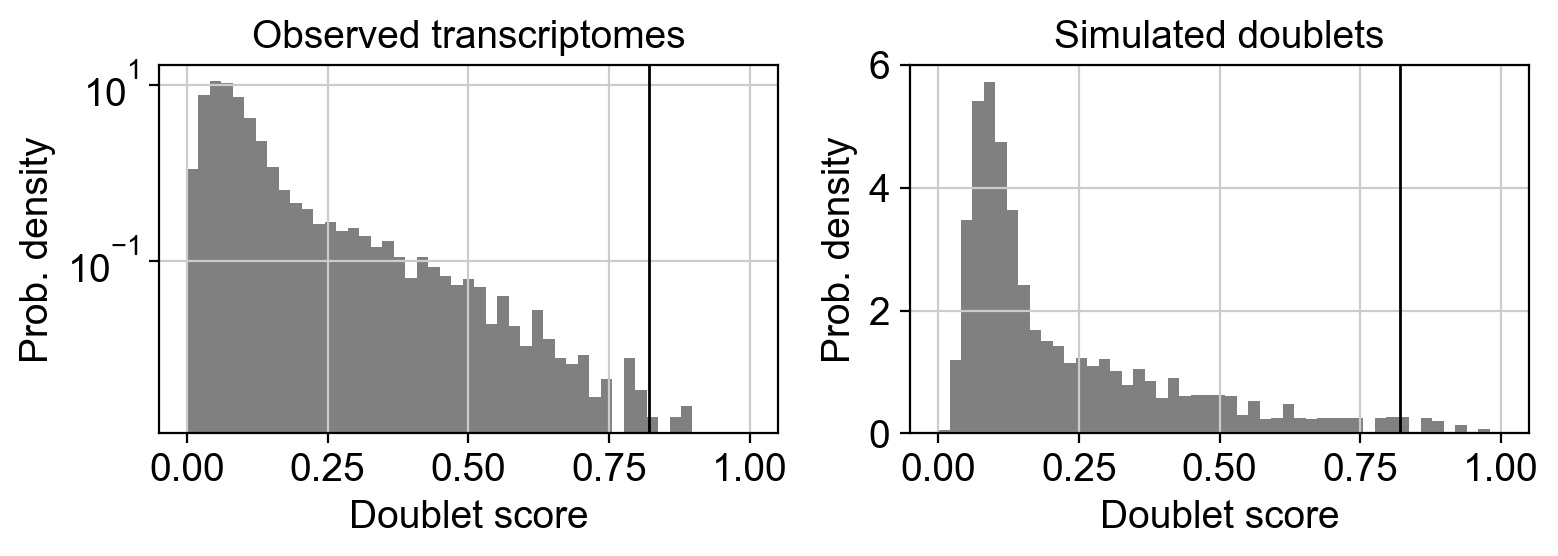

In [48]:
scrub.plot_histogram()

In [49]:
num_predicted_doublets = sum(adata.obs['predicted_doublets'])
print(f"Predicted {num_predicted_doublets} doublets")

Predicted 10 doublets


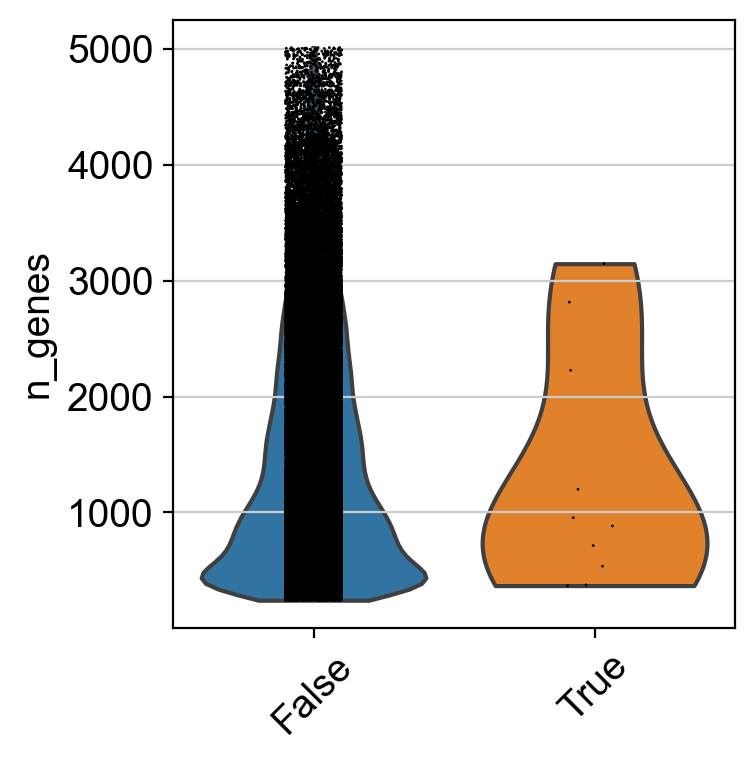

In [52]:
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)
sc.pl.violin(adata, 'n_genes',
             jitter=1, groupby = 'doublet_info', rotation=45,save='doublet.pdf')

In [54]:
adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(88076, 25375)


In [55]:
adata.write('./01.single data/scRNA_qc.h5ad')